## Описание данных
* timestamp – дата и время (точность до часа)
* cnt – количество аренд велосипедов за этот час
* t1 – температура, в С
* t2 – температура "ощущается как", в С 
* hum – влажность (%)
* wind_speed – скорость ветра, км/ч
* weather_code – погодные условия:

1 – ясно (SKC)

2 – преимущественно ясно / встречаются отдельные облака (SCT)

3 – облачно / значительные облака (BKN)

4 – пасмурно (OVC)

7 – небольшой дождь Rain/ light Rain shower/ Light rain 

10 – дождь с грозой

26 – снегопад 

94 – ледяной туман (да, такое бывает!)

* isholiday – является ли день праздником (1 – праздник, 0 – нет)
* isweekend –  является ли день выходным (1 – выходной, 0 – нет)
* season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

Загрузим данные, проверим число наблюдений и столбцов, наличие пропусков. Убедимся, что типы данных были прочитаны правильно. При необходимости – приведем переменные к нужным типам.**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('Solarize_Light2')

sns.set(

font_scale=2,

style="whitegrid",

rc={'figure.figsize':(20,7)}

    )

%matplotlib inline

In [75]:
london = pd.read_csv('/Users/pavel/Desktop/karpov/7 СТАТИСТИКА/3.6 london.csv', parse_dates=['timestamp'])
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [76]:
london.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

**Для начала попробуем посмотреть на число поездок по датам и времени. Построим график, где:**

* по оси x – дата (timestamp)
* по оси y – число поездок (cnt)

<Axes: xlabel='timestamp', ylabel='cnt'>

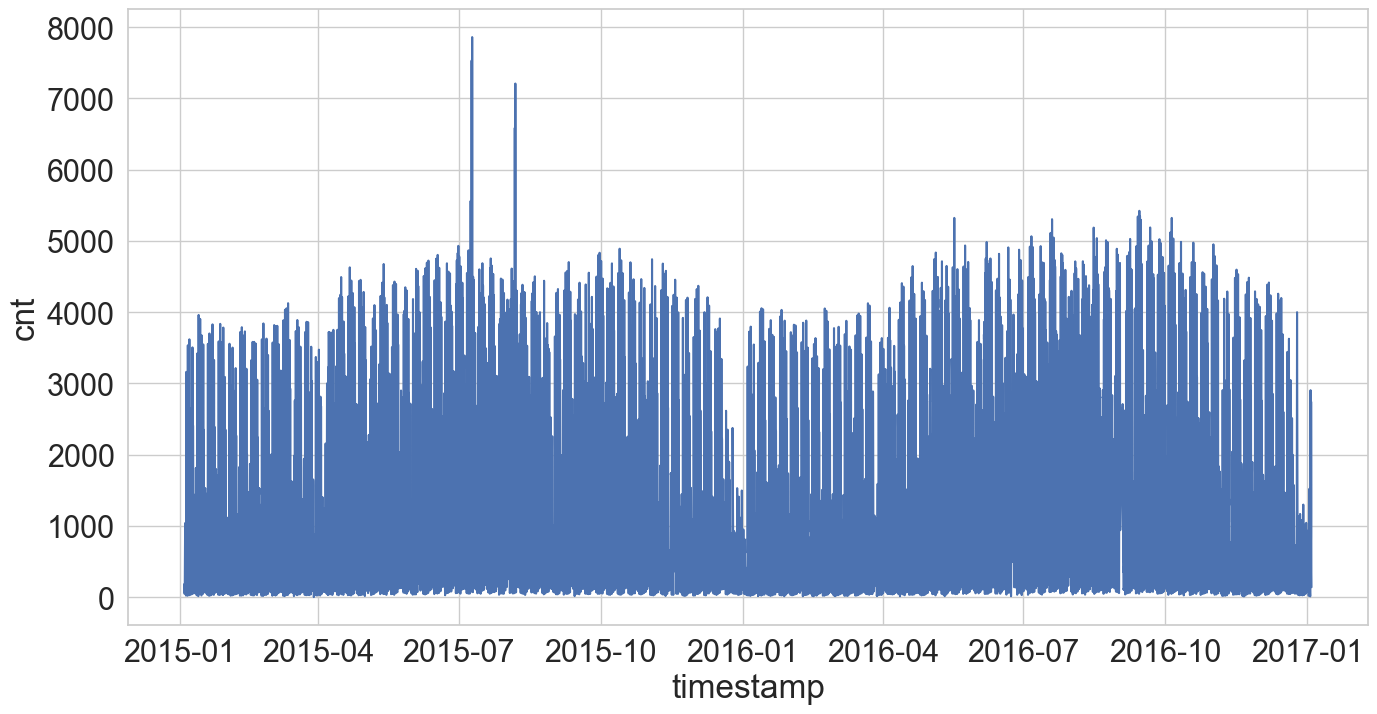

In [77]:
plt.figure(figsize=(16,8))
sns.lineplot(data = london, x = 'timestamp', y = 'cnt')

По этому графику мало, что можно сказать. Поэтому мы немного преобразуем данные. А также агрегируем число поездок по дням и визуализируйте результат.

In [78]:
london.set_index('timestamp', drop=False, inplace=True)

In [115]:
cnt_days = london.resample('D').agg({'cnt':'sum'}).reset_index()
cnt_days.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


<Axes: >

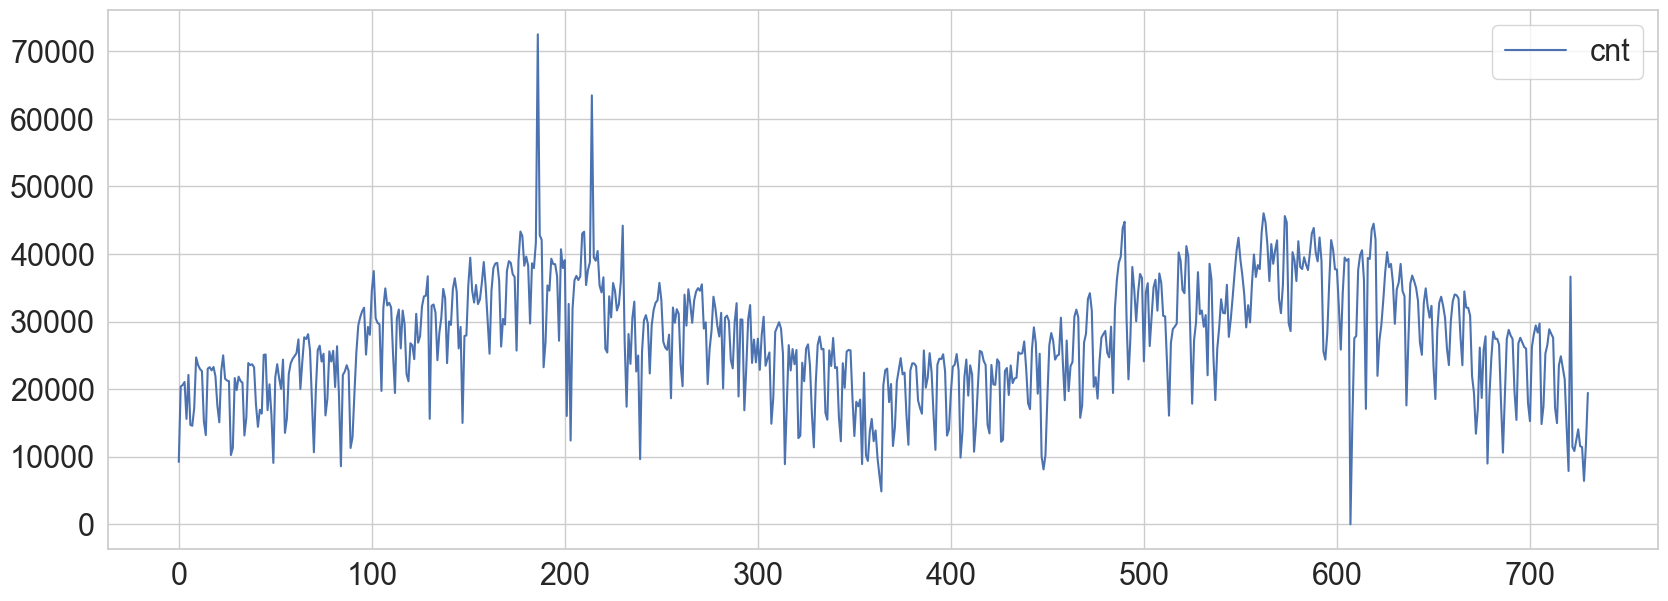

In [116]:
sns.lineplot(data = cnt_days)

* **Зимой число аренд меньше, чем летом**
* **Встречаются как очень резкие скачки числа аренд, так и падения**
* **Максимальное число аренд за день составляет более 70 000**


Мы обнаружили на графике некоторые скачки.

Для этого разделим дальнейшие действия на несколько этапов:

* сначала посчитаем скользящее среднее, чтобы сгладить ряд
* далее – разницу между наблюдаемыми и сглаженными значениями
* определим верхние и нижние границы 99% доверительного интервала 
* найдем причины аномалий!

На данном шаге возьмем агрегированные данные по дням с предыдущего шага и посчитаем скользящее среднее с окном 3.

In [117]:
cnt_days.cnt.rolling(window = 3).mean()

0               NaN
1               NaN
2      16739.666667
3      20683.000000
4      19092.666667
           ...     
726    12682.000000
727    12347.333333
728     9803.666667
729     9889.333333
730    12560.000000
Name: cnt, Length: 731, dtype: float64

In [118]:
cnt_days['rolling_mean'] = cnt_days.cnt.rolling(window = 3).mean()
cnt_days.head()

,timestamp,cnt,rolling_mean
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667


In [126]:
cnt_days.query("timestamp == '2015-07-09'")['rolling_mean'].round()

186    50705.0
Name: rolling_mean, dtype: float64

Теперь посчитаем разницу между наблюдаемыми и подсчитанными значениями. Далее – применим функцию для подсчета стандартного отклонения. Например:
```
c = a - b
std = np.std(c)
```

In [157]:
cnt_days['delta'] = cnt_days.cnt - cnt_days.rolling_mean

In [161]:
delta_std = np.std(cnt_days.cnt - cnt_days.rolling_mean)
delta_std.round(2)

4558.59

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

* upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
* lower_bound – нижняя граница; вычитаем 2.576∗std

Полученные значения запишем в новые столбцы датафрейма с агрегированными данными.

In [162]:
cnt_days['upper_bound'] = cnt_days.rolling_mean + (2.576*delta_std)
cnt_days['lower_bound'] = cnt_days.rolling_mean - (2.576*delta_std)

In [163]:
cnt_days.iloc[-1].upper_bound.round(2)

24302.92

И наконец – изучим аномально высокие значения! Сначала выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим?

In [172]:
cnt_days.query("cnt > upper_bound")

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


In [211]:
cnt_days[cnt_days.cnt == cnt_days.query('cnt > upper_bound').cnt.max()]

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
186,2015-07-09,72504,50705.0,21799.0,62447.919188,38962.080812


В чем может быть причина столь высокого числа аренд в этот день. Для этого можем исследовать уже имеющиеся переменные в датасете, проверить наличие ошибок в данных (повторяющихся строк), а также использовать поиск Google. 


Проделаем аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

In [207]:
cnt_days.query("cnt < lower_bound")

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812


Скорее всего ошибка заключается при сборе данных

In [209]:
cnt_days[cnt_days.cnt == cnt_days.query('cnt < lower_bound').cnt.min()]

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
